# Linear Regression Analysis: A Comparative Study of Solution Methods

---

### Overview

This computational study examines different methodologies for solving linear regression problems, with particular emphasis on their numerical properties and performance characteristics.

### Objectives

* Compare direct analytical methods (Normal Equations, SVD) with iterative optimization (BGD, SGD)
* Investigate numerical stability when dealing with ill-conditioned feature matrices
* Analyze convergence behavior and computational efficiency of gradient-based methods
* Extend linear models to polynomial regression for capturing non-linear patterns

### Dataset & Methodology

The analysis begins with controlled synthetic examples to isolate specific numerical phenomena, then progresses to real-world automotive data (Auto MPG dataset) for practical validation. Multiple regression solvers are implemented and benchmarked across different scenarios including multicollinearity challenges and large-scale optimization tasks.

---

## Section 1: Environment Setup and Library Configuration

This section imports all necessary libraries and configures the computational environment for reproducible results.

In [86]:
"""
============================================================
Library Imports
============================================================
"""

import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42)  # Reproducibility configuration

warnings.filterwarnings("ignore")

---

## Section 2: Regression Methods Comparison on Synthetic Data

This section demonstrates three different approaches to solving linear regression on a small synthetic dataset: Normal Equations, Batch Gradient Descent (BGD), and Singular Value Decomposition (SVD). We compare their computational behavior and accuracy.

In [87]:
"""
============================================================
Define Initial Dataset (Small Scale)
============================================================
"""

# Design matrix X_mat: [Intercept, Feature]
X_mat = np.array ([
    [1, 2.0],
    [1, 3.0],
    [1, 4.5],
    [1, 5.5]
])

# Response vector y_vec: Target observations
y_vec = np.array ([
    [3.1],
    [4.9],
    [8.2],
    [10.1]
])

num_samples = len(y_vec)  # Total observations

print(f"Matrix X_mat shape: {X_mat.shape}, Vector y_vec shape: {y_vec.shape}")

Matrix X_mat shape: (4, 2), Vector y_vec shape: (4, 1)


In [88]:
"""
============================================================
Solve Using Normal Equations
============================================================
"""

# Apply formula: (X^T * X)^-1 * X^T * y
weights = np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ y_vec

print("Weights from normal equation:\n", weights)

Weights from normal equation:
 [[-1.04137931]
 [ 2.03103448]]


In [89]:
"""
============================================================
Solve Using Batch Gradient Descent (BGD)
============================================================
"""

weights_bgd = np.zeros((X_mat.shape[1], 1))  # Weight initialization

alpha = 0.01
max_iters = 1000

for _ in range(max_iters):
    # Compute gradient over entire dataset
    grad = (1 / num_samples) * X_mat.T @ (X_mat @ weights_bgd - y_vec)
    
    # Weight update step
    weights_bgd = weights_bgd - alpha * grad

print("Final weights from BGD:\n", weights_bgd)

Final weights from BGD:
 [[-0.55217831]
 [ 1.9146829 ]]


In [90]:
"""
============================================================
Solve Using SVD (Pseudoinverse Approach)
============================================================
"""

# Perform SVD decomposition
U_matrix, singular_vals, VT_matrix = np.linalg.svd(X_mat, full_matrices=False)

# Compute reciprocals of singular values
singular_inv = np.array([1/val if val > 1e-12 else 0 for val in singular_vals])

Sigma_inv = np.diag(singular_inv)

# Calculate Moore-Penrose pseudoinverse
X_pseudoinv = VT_matrix.T @ Sigma_inv @ U_matrix.T

# Obtain weights
weights_svd = X_pseudoinv @ y_vec

print("Final weights from SVD:\n", weights_svd)

Final weights from SVD:
 [[-1.04137931]
 [ 2.03103448]]


---

## Section 3: Numerical Stability Analysis with Collinear Features

This section investigates how Normal Equations and SVD handle multicollinearity. By introducing near-duplicate features, we demonstrate the numerical instability of matrix inversion versus the robust behavior of SVD.

In [91]:
"""
============================================================
Generate Collinear Dataset
============================================================
"""

perturbation = np.random.rand(num_samples, 1) * 1e-12  # Add small perturbation to create near-duplicate column

X_collinear = np.hstack((X_mat, X_mat[:, [1]] + perturbation))

In [92]:
print("Matrix X (Collinear):\n", X_collinear)

Matrix X (Collinear):
 [[1.  2.  2. ]
 [1.  3.  3. ]
 [1.  4.5 4.5]
 [1.  5.5 5.5]]


In [93]:
"""
============================================================
Normal Equations With Collinear Features
============================================================
Warning: May yield unstable results due to near-singularity
"""

XTX_col = X_collinear.T @ X_collinear
XTy_col = X_collinear.T @ y_vec

weights_col_normal = np.linalg.inv(XTX_col) @ XTy_col

print("Weights from normal equations (Collinear):\n", weights_col_normal)

Weights from normal equations (Collinear):
 [[ 0.91293103]
 [ 5.084375  ]
 [-3.06757813]]


In [94]:
"""
============================================================
SVD With Collinear Features
============================================================
"""

U_matrix, singular_vals, VT_matrix = np.linalg.svd(X_collinear, full_matrices=False)

# Careful handling of singular values
singular_inv = np.array([1/val if val > 1e-12 else 0 for val in singular_vals])

Sigma_inv = np.diag(singular_inv)
X_pseudoinv = VT_matrix.T @ Sigma_inv @ U_matrix.T

weights_col_svd = X_pseudoinv @ y_vec

print("Final weights from SVD (Collinear):\n", weights_col_svd)

Final weights from SVD (Collinear):
 [[-1.04137931]
 [ 1.01551724]
 [ 1.01551724]]


---

## Section 4: Real-World Dataset Analysis - Auto MPG

This section transitions to a real-world dataset (Auto MPG) to analyze the relationship between vehicle horsepower and fuel efficiency. We prepare the data through cleaning and standardization for gradient descent optimization.

In [95]:
"""
============================================================
Load and Preprocess Data
============================================================
"""

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

col_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower',
    'Weight', 'Acceleration', 'ModelYear', 'Origin', 'CarName'
]

# Read dataset with missing value handling
df_mpg = pd.read_csv(
    data_url,
    names=col_names,
    na_values='?',
    delim_whitespace=True
)

df_mpg = df_mpg.dropna(subset=['Horsepower'])  # Remove rows with missing values and ensure proper type
df_mpg['Horsepower'] = df_mpg['Horsepower'].astype(float)

df_mpg.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin,CarName
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [96]:
"""
============================================================
Prepare Input Matrices & Standardization
============================================================
"""

feature_data = df_mpg['Horsepower'].values.reshape(-1, 1)  # Extract features and targets: Horsepower -> MPG
target_data = df_mpg['MPG'].values.reshape(-1, 1)

# Standardize features to improve convergence speed (Critical for GD)
normalizer = StandardScaler()
feature_scaled = normalizer.fit_transform(feature_data)

# Augment with intercept term (bias column)
X_mat = np.hstack([np.ones((feature_scaled.shape[0], 1)), feature_scaled])

num_samples = len(target_data)

print("Shape of X_mat:", X_mat.shape)
print("Shape of target_data:", target_data.shape)

Shape of X_mat: (392, 2)
Shape of target_data: (392, 1)


---

## Section 5: Convergence Analysis - BGD vs SGD

This section implements and compares two gradient descent variants: Batch Gradient Descent (BGD) which uses the full dataset per iteration, and Stochastic Gradient Descent (SGD) which updates weights using single random samples. We track and visualize their convergence patterns.

In [97]:
"""
============================================================
BGD Training & Loss Monitoring
============================================================
"""

def calculate_loss(X_mat, target_data, weights):
    error = X_mat @ weights - target_data
    return (error.T @ error) / (2 * num_samples)

weights_bgd = np.zeros((X_mat.shape[1], 1))
loss_bgd = []

alpha = 0.01
max_iters = 1000

for _ in range(max_iters):
    # Update with complete dataset
    grad = (1 / num_samples) * X_mat.T @ (X_mat @ weights_bgd - target_data)
    weights_bgd = weights_bgd - alpha * grad
    
    # Track loss progression
    loss_bgd.append(calculate_loss(X_mat, target_data, weights_bgd))

print("Final weights from BGD:\n", weights_bgd)

Final weights from BGD:
 [[23.44490618]
 [-6.06761045]]


In [98]:
"""
============================================================
SGD Training Function
============================================================
"""

def stochastic_gradient_descent(X_mat, target_data, alpha=0.01, max_iters=5000):
    n_samples, n_features = X_mat.shape
    
    weights = np.zeros((n_features,1))
    loss_history = []
    
    for _ in range(max_iters):
        idx = np.random.randint(0, n_samples)  # Select random sample
        
        X_i = X_mat[idx:idx+1, :]
        y_i = target_data[idx:idx+1, :]
        
        # Update based on single sample
        gradient_i = X_i.T @ (X_i @ weights - y_i)
        weights = weights - alpha * gradient_i
        
        # Record overall loss for tracking
        loss_history.append(calculate_loss(X_mat, target_data, weights))
    
    return weights, loss_history

weights_sgd, loss_sgd = stochastic_gradient_descent(X_mat, target_data, alpha=0.01, max_iters=5000)

print("Final weights from SGD:\n", weights_sgd)

Final weights from SGD:
 [[22.5832758 ]
 [-6.51916008]]


In [99]:
# Reshape loss arrays for visualization
loss_bgd = np.array(loss_bgd).reshape(-1,)
loss_sgd = np.array(loss_sgd).reshape(-1,)

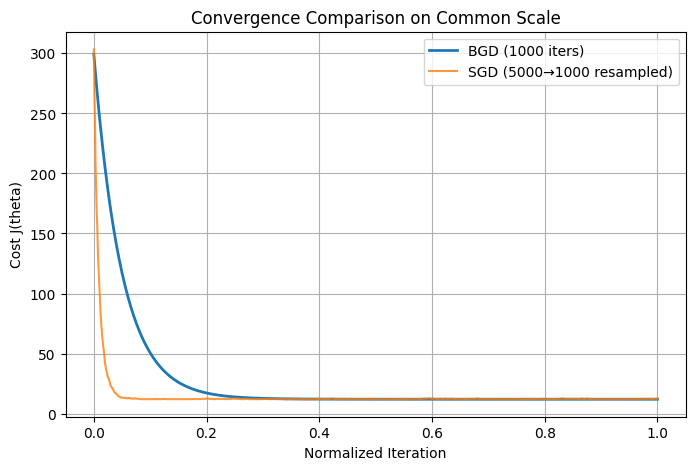

In [100]:
"""
============================================================
Convergence Visualization (BGD vs SGD with Interpolation)
============================================================
Map iteration indices to normalized [0, 1] scale for comparison.
This enables side-by-side analysis despite different iteration counts.
"""

bgd_norm_x = np.linspace(0, 1, len(loss_bgd))
sgd_norm_x = np.linspace(0, 1, len(loss_sgd))

# Interpolate SGD loss to match BGD length using linear method
# Creates comparable convergence trajectory for visualization
sgd_interpolated = np.interp(bgd_norm_x, sgd_norm_x, loss_sgd)

# Generate comparative plot on normalized scale
plt.figure(figsize=(8,5))
plt.plot(bgd_norm_x, loss_bgd, label='BGD (1000 iters)', linewidth=2)
plt.plot(bgd_norm_x, sgd_interpolated, label='SGD (5000→1000 resampled)', alpha=0.8)

# Configure plot aesthetics
plt.xlabel("Normalized Iteration")
plt.ylabel("Cost J(theta)")
plt.title("Convergence Comparison on Common Scale")
plt.legend()
plt.grid(True)
plt.show()

---

## Section 6: Polynomial Regression with SGD

This section extends linear regression to polynomial regression by engineering quadratic features. Using SGD for optimization, we model the non-linear relationship between horsepower and MPG to capture curvature in the data.

In [101]:
"""
============================================================
Polynomial Feature Construction
============================================================
"""

features_poly = np.hstack([feature_data, feature_data**2])  # Generate quadratic feature

# Standardize polynomial features
normalizer_poly = StandardScaler()
features_poly_scaled = normalizer_poly.fit_transform(features_poly)

# Add intercept column
X_poly_mat = np.hstack([np.ones((features_poly_scaled.shape[0], 1)), features_poly_scaled])

print("Shape of X_poly_mat:", X_poly_mat.shape)
print("Shape of target_data:", target_data.shape)

Shape of X_poly_mat: (392, 3)
Shape of target_data: (392, 1)


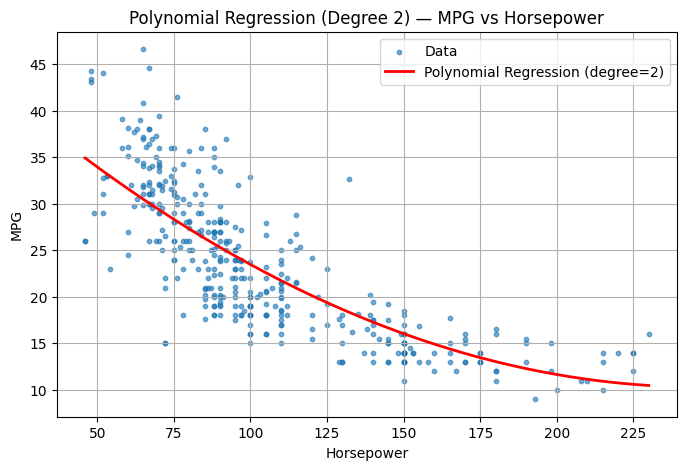

In [102]:
"""
============================================================
Train and Display Polynomial Regression
============================================================
"""

x_grid = np.linspace(feature_data.min(), feature_data.max(), 300).reshape(-1,1)  # Create prediction grid for smooth curve

# Apply polynomial transformation and scaling to grid
x_grid_poly = np.hstack([x_grid, x_grid**2])
x_grid_poly_scaled = normalizer_poly.transform(x_grid_poly)

X_grid_mat = np.hstack([np.ones((x_grid_poly_scaled.shape[0],1)), x_grid_poly_scaled])

# Train polynomial model via SGD (Optimized approach)
weights_poly, loss_poly = stochastic_gradient_descent(X_poly_mat, target_data, alpha=0.01, max_iters=5000)

y_pred = X_grid_mat @ weights_poly  # Generate predictions for visualization

# Create visualization
plt.figure(figsize=(8,5))
plt.scatter(feature_data, target_data, s=10, alpha=0.6, label='Data')
plt.plot(x_grid, y_pred, color='red', linewidth=2, label='Polynomial Regression (degree=2)')
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Polynomial Regression (Degree 2) — MPG vs Horsepower")
plt.grid(True)
plt.legend()
plt.show()